# Image Backgound Removal

### Introduction and Objective

This project demonstrates the use of the U-2-NETp model for various image processing tasks, including background removal, bounding box creation, and salient feature highlighting. U-2-NETp is a lightweight model designed specifically for salient object detection, offering a balance between performance and computational efficiency. This makes it suitable for real-time applications where resources may be limited.

The primary objective of this project is to showcase the capabilities of U-2-NETp in handling common image processing tasks by leveraging deep learning techniques. Users can upload their images to the system, which then processes these images to remove backgrounds, create bounding boxes around detected objects, and highlight salient features. The processed images can be used for various applications such as image editing, object detection, and feature extraction.

### Ensure Proper Folder Structure

To ensure that the notebook runs correctly, it is important to have the proper folder structure. The following folders should be created in the project root directory:

- `images`: This folder will store the user-uploaded images.
- `results`: This folder will store the processed images generated by the U-2-NETp model.

Ensure that these directories are created before running the notebook cells. The paths within the notebook and the `u2net_test.py` script have been adjusted to use these directories.

### Sample Images
There are already 3 sample images available in the images folder. If you want to see the results without uploading your own images, you can skip the upload cell and run the next cell to see the results.

### Model Usage

The trained U-2-NETp model can be used for the following tasks:
- **Background Removal**: This removes the background from images, isolating the main object.
- **Bounding Box Creation**: This draws bounding boxes around the detected objects in the images.
- **Salient Feature Highlighting**: This highlights the most salient features in the images.

### How To Use


1. **Run the Notebook:**

   - Open the `U_2_Netp_Demonstration_Colab.ipynb` notebook in a Jupyter environment.
   - Execute the notebook cells sequentially to perform data analysis, model training, and evaluation.

2. **Model Usage:**

   - Upload images using the function provided in the notebook.
   - The images will be stored in the `images` folder.
   - Run the `u2net_test.py` script to process the images and store the results in the `results` folder.
   - Use the processed images for background removal, bounding box creation, and salient feature highlighting.
  
**Note:** 
- The libraries required for this project are already available in the CTPO environment, so there is no need to create a virtual environment.
- Make Sure Images are in `jpeg` format 

In [1]:
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display, Image
import os
target_directory = 'images'

# Ensure the target directory exists
if not os.path.exists(target_directory):
    print(f"Directory {target_directory} does not exist.")
else:
    print(f"Target directory: {target_directory}")

# Function to handle uploaded files
def handle_upload(change):
    print("Upload started...")
    # Print the structure of 'change' to understand its content
    print(change)
    
    for file_upload in change['new']:
        print(f"Handling file: {file_upload}")
        filepath = os.path.join(target_directory, file_upload['name'])
        print(f"Saving to: {filepath}")
        with open(filepath, 'wb') as f:
            f.write(file_upload['content'])
        print(f'Saved {file_upload["name"]} to {filepath}')
    # List the files in the target directory after upload
    print(f'Files in target directory ({target_directory}): {list(Path(target_directory).glob("*"))}')
    print("Upload completed.")

# Create an output widget to capture print statements
output = widgets.Output()

# Create an upload widget
upload_widget = widgets.FileUpload()

# Function to handle the change event using output widget
def handle_upload_with_output(change):
    with output:
        handle_upload(change)

# Attach the observer to the upload widget
upload_widget.observe(handle_upload_with_output, names='value')

# Display the upload widget and output widget
display(upload_widget, output)

Target directory: images


FileUpload(value=(), description='Upload')

Output()

### `u2net_test.py` Script Execution

The below command runs the `u2net_test.py` script, which:

1. **Loads Images**: Reads images from the `images` directory using `glob`.
2. **Prepares Data**: Uses a custom dataset (`SalObjDataset`) and applies transformations (resizing and tensor conversion) to prepare images for model input.
3. **Loads Model**: Loads the pre-trained U2NET or U2NETP model, which are used for salient object detection, image background removal, and creating bounding boxes.
4. **Inference**: Processes each image to generate segmentation maps, normalizes the predictions, and saves the results in the `results` directory.

In [2]:
!python -W ignore u2net_test.py

['/iti/Background_Removal/images/images01.jpeg', '/iti/Background_Removal/images/images02.jpeg', '/iti/Background_Removal/images/images03.jpeg']
...load U2NEP---4.7 MB
inferencing: images01.jpeg
inferencing: images02.jpeg
inferencing: images03.jpeg


2024-07-15 18:36:24.028946: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1. Original Image, 2. Background Removed Image, 3. Bounding Box Detected Image, 4. Salient Feature Highlighted Image
images01


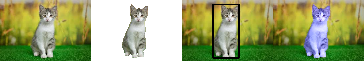

images02


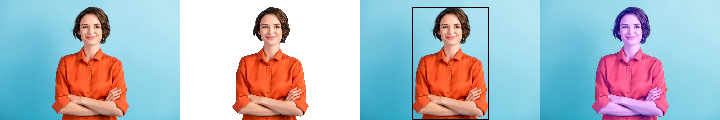

images03


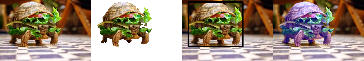

In [3]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
from PIL import Image as Img
import cv2



image_dir = os.path.join(os.getcwd(), 'results')
names = [name[:-4] for name in os.listdir(image_dir)]
THRESHOLD = 0.9
RESCALE = 255
LAYER = 2
COLOR = (0, 0, 0)
THICKNESS = 4
SAL_SHIFT = 100

print('1. Original Image, 2. Background Removed Image, 3. Bounding Box Detected Image, 4. Salient Feature Highlighted Image')
for name in names:

  # BACKGROUND REMOVAL

  if name == '.ipynb_checkpo':
    continue
  print(name)  
  output = load_img('results/'+name+'.png')
  out_img = img_to_array(output)
  out_img /= RESCALE

  out_img[out_img > THRESHOLD] = 1
  out_img[out_img <= THRESHOLD] = 0

  shape = out_img.shape
  a_layer_init = np.ones(shape = (shape[0],shape[1],1))
  mul_layer = np.expand_dims(out_img[:,:,0],axis=2)
  a_layer = mul_layer*a_layer_init
  rgba_out = np.append(out_img,a_layer,axis=2)

  input = load_img('images/'+name+'.jpeg')
  inp_img = img_to_array(input)
  inp_img /= RESCALE

  a_layer = np.ones(shape = (shape[0],shape[1],1))
  rgba_inp = np.append(inp_img,a_layer,axis=2)

  rem_back = (rgba_inp*rgba_out)
  rem_back_scaled = rem_back*RESCALE

  # BOUNDING BOX CREATION

  out_layer = out_img[:,:,LAYER]
  x_starts = [np.where(out_layer[i]==1)[0][0] if len(np.where(out_layer[i]==1)[0])!=0 else out_layer.shape[0]+1 for i in range(out_layer.shape[0])]
  x_ends = [np.where(out_layer[i]==1)[0][-1] if len(np.where(out_layer[i]==1)[0])!=0 else 0 for i in range(out_layer.shape[0])]
  y_starts = [np.where(out_layer.T[i]==1)[0][0] if len(np.where(out_layer.T[i]==1)[0])!=0 else out_layer.T.shape[0]+1 for i in range(out_layer.T.shape[0])]
  y_ends = [np.where(out_layer.T[i]==1)[0][-1] if len(np.where(out_layer.T[i]==1)[0])!=0 else 0 for i in range(out_layer.T.shape[0])]
  
  startx = min(x_starts)
  endx = max(x_ends)
  starty = min(y_starts)
  endy = max(y_ends)
  start = (startx,starty)
  end = (endx,endy)

  box_img = inp_img.copy()
  box_img = cv2.rectangle(box_img, start, end, COLOR, THICKNESS)
  box_img = np.append(box_img,a_layer,axis=2)
  box_img_scaled = box_img*RESCALE

  # SALIENT FEATURE MAP

  sal_img = inp_img.copy()
  add_layer = out_img.copy()
  add_layer[add_layer==1] = SAL_SHIFT/RESCALE
  sal_img[:,:,LAYER] += add_layer[:,:,LAYER]
  sal_img = np.append(sal_img,a_layer,axis=2)
  sal_img_scaled = sal_img*RESCALE
  sal_img_scaled[sal_img_scaled>RESCALE] = RESCALE

  # OUTPUT RESULTS

  inp_img*=RESCALE
  inp_img = np.append(inp_img,RESCALE*a_layer,axis=2)
  inp_img = cv2.resize(inp_img,(int(shape[1]/3),int(shape[0]/3)))
  rem_back = cv2.resize(rem_back_scaled,(int(shape[1]/3),int(shape[0]/3)))
  box_img = cv2.resize(box_img_scaled,(int(shape[1]/3),int(shape[0]/3)))
  sal_img = cv2.resize(sal_img_scaled,(int(shape[1]/3),int(shape[0]/3)))
  result = np.concatenate((inp_img,rem_back,box_img,sal_img),axis=1)
  result_img = Img.fromarray(result.astype('uint8'), 'RGBA')

  display(result_img)